# Face Verification
**GitHub:** https://github.com/pirsquareff/fisherface

For the rest of the homework we will work on face verification (Given a face, say whether it is person A or not). Face verification is quite related to face recog- nition (Given a face, say who it is). Face verification is a binary classification task, while face recognition is a multi-class problem.

Download the file `facedata.mat` from myCourseVille and import it

In [43]:
import numpy as np
from IPython.display import Latex
from IPython.display import Math
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
import copy

In [44]:
import scipy.io
data = scipy.io.loadmat("data/facedata.mat")

`data` is a dictionary with key value pairs. The data you want to use can be accessed by using `facedata` as the key.

(40, 10)
[[48 46 50 ..., 50 54 53]
 [47 47 48 ..., 37 46 50]
 [46 48 43 ..., 33 41 51]
 ..., 
 [49 49 50 ..., 45 46 47]
 [48 48 49 ..., 45 46 46]
 [51 48 50 ..., 45 45 46]]
(56, 46)


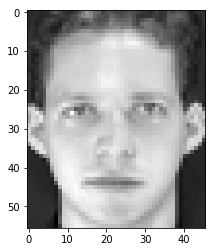

In [45]:
# face data is a 2-dimensional array with size 40x10
print(data["facedata"].shape)
# Each data is indexed by i and j
# where i is the person index
# j is the index of the pose
# In other words, there are 40 people in the database.
# There are 10 images per person.
n_person = data["facedata"].shape[0]
n_image_per_person = data["facedata"].shape[1]
print(data["facedata"][0, 0])

# Each image is a 56 by 46 image
image_resolution = np.array([56, 46])
print(data["facedata"][0, 0].shape)

# You can see the image by using the imshow in matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(data["facedata"][0, 0], cmap = "gray")
plt.show()

## Working with images
Each pixel in an image is usually represented by a 8-bit unsigned integer (values from 0 to 255). In order to easily work on images, we usually convert them to floats or doubles using the following command.

`xf[0, 0] = img_as_float(data["facedata"][0, 0])`

In [46]:
from skimage import img_as_float
xf = {}
for i in range(n_person):
    for j in range(n_image_per_person):
        xf[i, j] = img_as_float(data["facedata"][i, j])

`img_as_float` scales 0-255 to 0-1. You can still show the image using the same `imshow` command.

Note that the index of a 2D image starts from the upper left corner of the image. The first dimension goes downwards, while the second dimension goes to the right (think of it as a matrix). To understand what this means, try the following code.

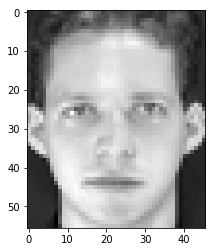

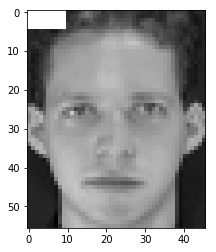

In [47]:
plt.imshow(xf[0, 0], cmap = "gray")
plt.show()
x_temp = copy.deepcopy(xf[0, 0])
x_temp[0:5, 0:10] = 1
# In float format, 1 is white
plt.imshow(x_temp, cmap = "gray")
plt.show()

## The similarity matrix
Consider a set of $N$ data points, a similarity matrix $S$ is a matrix where $S_{i,j}$ is the distance between the $i^{th}$ and the $j^{th}$ data point. A similarity matrix can be very useful for analyzing the data and its distribution. Since a similarity matrix can also be considered as an image, you can also show it as an image to see the pattern in the data.

But how do we define similarity? How can we quantify whether image $A$ is closer to $B$ than image $C$? One way is to treat each pixel in image as an element in a vector (you may find the function `numpy.reshape()` useful). Then, compare the two vectors using Euclidean distance.

Euclidean distance between vector $x$ and $y$ is defined as:
$$Euclidean\_distance =  \sqrt{Σ_{d}(x_{d} − y_{d})^{2}}$$
where $d$ refers to the index of the dimension.

**What is the Euclidean distance between `xf[0,0]` and `xf[0,1]`?**
<font color=red>**Answer**</font><br>
The Euclidean distance between `xf[0,0]` and `xf[0,1]` is 10.0376162942

In [48]:
def euclidean_distance(x, y):
    """
    :x: a vector with shape nxm
    :y: a vector with shape nxm
    :Returns: Euclidean distance between vector x and y
    """
    _x = np.reshape(x, np.prod(x.shape))
    _y = np.reshape(y, np.prod(y.shape))
    return np.sqrt(np.sum((_x - _y) ** 2))

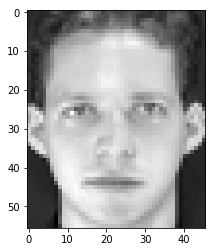

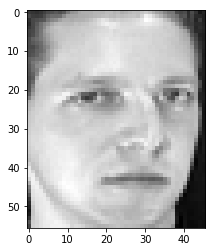

<IPython.core.display.Math object>

In [49]:
plt.imshow(xf[0, 0], cmap = "gray")
plt.show()

plt.imshow(xf[0, 1], cmap = "gray")
plt.show()

display(Math(r"Euclidean\ distance\ between\ xf[0,0]\ and\ xf[0,1]: " + str(euclidean_distance(xf[0, 0], xf[0, 1]))))

**What is the Euclidean distance between `xf[0,0]` and `xf[1,0]`?**
<font color=red>**Answer**</font><br>
The Euclidean distance between `xf[0,0]` and `xf[1,0]` is 8.17329509974

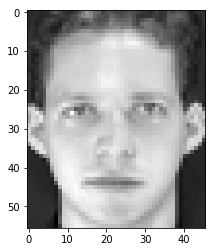

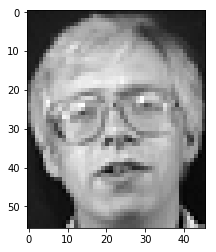

<IPython.core.display.Math object>

In [50]:
plt.imshow(xf[0, 0], cmap = "gray")
plt.show()

plt.imshow(xf[1, 0], cmap = "gray")
plt.show()

display(Math(r"Euclidean\ distance\ between\ xf[0,0]\ and\ xf[1,0]: " + str(euclidean_distance(xf[0, 0], xf[1, 0]))))

**Does the numbers make sense? Do you think these numbers will be useful for face verification?**
<font color=red>**Answer**</font><br>
Based on the example above, these numbers make sense and seem to be useful for verifying faces, but using only Euclidean distance might not be able to achieve high accuracy.

As we continue our exercise, we will refine our feature vectors so that the Euclidean distance between two images can be used in a face verification system. We define the similarity matrix, $A$, as a matrix whose elements $A_{i, j}$ is the Euclidean distance between data sample $i$ from list $T$ and data sample $j$ from
list $D$, where list $T$, $D$ are lists of data samples.

In [51]:
def similarity_matrix(M, N):
    """
    :M: a 2D image list
    :N: a 2D image list
    :Returns: similarity matrix
    """
    return np.array([[euclidean_distance(N[j], M[i]) for j in range(len(N))] for i in range(len(M))])

The picture below shows an example similarity matrix calculated by the first 5 images from the first 5 people (for both $T$ and $D$).

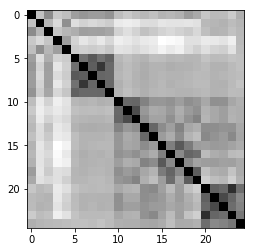

In [52]:
T_sample = []
for i in range(n_person):
    for j in range(n_image_per_person):
        if(i < 5 and j < 5):
            # training image
            T_sample.append(xf[i, j])
A_sample = similarity_matrix(T_sample, T_sample)
A_sample_f = img_as_float(A_sample)
plt.imshow(A_sample_f, cmap = "gray")
plt.show()

**From the example similarity matrix above, what does the black square between `[5:10, 5:10]` suggest about the pictures from person number 2? What do the patterns from person number 1 say about the images from person 1?**
<font color=red>**Answer**</font><br>
The black square between `[5:10, 5:10]` suggests that the first five images of person number 2 are very similar based on similarity using Euclidean distance, whereas the pattern between `[0:5, 0:5]` with lighter off-diagonal pixels suggests that the first five images of person 1 are considered to be unsimilar.

**Write a function that takes in a set of feature vectors $T$ and a set of feature vectors $D$, and then output the similarity matrix $A$. Show the matrix as an image. Use the feature vectors from the first 3 images from all 40 people
for list $T$ (in order `x[0, 0], x[0, 1], x[0, 2], x[1, 0], x[1, 1], ..., x[39, 2]`). Use the feature vectors from the remaining 7 images from all 40 people for list $D$ (in order `x[0, 3], x[0, 4], x[0, 5], x[1, 6], x[0, 7], x[0, 8], x[0, 9], x[1, 3], x[1, 4]...x[39, 9]`). We will treat $T$ as our training images and $D$ as our testing images**
<font color=red>**Answer**</font><br>
The answer is in the code cells below.

In [53]:
T = [] # training images
D = [] # testing images
for i in range(n_person):
    for j in range(n_image_per_person):
        if(j < 3):
            # training image
            T.append(xf[i, j])
        else:
            # testing image
            D.append(xf[i, j])

In [54]:
A = similarity_matrix(T, D)

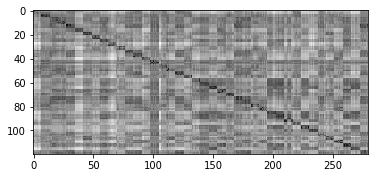

In [55]:
A_f = img_as_float(A)
plt.imshow(A_f, cmap = "gray")
plt.show()

## A simple face verification system
In our simple face verification system, given a test image, we want to test if that image comes from person $A$ or not. We will compare the test image against the three training images from person $A$ we have. If the minimum distance (between the three training images) is below a threshold, $t$, we say that the test image is person $A$.

**Write a function that takes in the similarity matrix created from the previous part, and a threshold $t$ as inputs. The outputs of the function are the true positive rate and the false alarm rate of the face verification task ($280$ Test images, tested on $40$ people, a total of $11200$ testing per threshold). What is the true positive rate and the false alarm rate for $t = 140$?**
<font color=red>**Answer**</font><br>
Given $t = 140$,<br>
**True positive rate:** 1.000000<br>
**False alarm rate:** 1.000000<br>
The `verify_faces` function is defined in the cell below.

In [104]:
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred, normalize = True)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, precision, recall, f1

In [142]:
# construct ground truth
ground_truth = np.zeros((n_person, A.shape[1]))
for i in range(n_person):
    for j in range(A.shape[1]):
        if(j >= 7 * i and j <= 7 * i + 6):
            ground_truth[i][j] = 1
            
_ground_truth = np.reshape(ground_truth, np.prod(ground_truth.shape))
            
ground_truth_unique, ground_truth_counts = np.unique(_ground_truth, return_counts = True)
ground_truth_dict = dict(zip(ground_truth_unique, ground_truth_counts))

n_pos = ground_truth_dict[1]
n_neg = ground_truth_dict[0]

                
def verify_faces(t):
    """
    :t: threshold
    :Returns: true positive and false alarm rate
    """
    result = np.zeros((n_person, A.shape[1]))
    for i in range(n_person):
        for j in range(A.shape[1]):
            if(np.amin([A[3 * i + k][j] for k in range(3)]) < t):
                result[i][j] = 1

    _result = np.reshape(result, np.prod(result.shape))                
    
    tn, fp, fn, tp = confusion_matrix(_ground_truth, _result).ravel()
    
    return tp / n_pos, fp / n_neg

In [143]:
tpr_t_140, fpr_t_140 = verify_faces(140)
print("True positive rate: {0:f}\nFalse alarm rate: {1:f}".format(tpr_t_140, fpr_t_140))

True positive rate: 1.000000
False alarm rate: 1.000000


**Plot the RoC curve for this simple verification system. What should be the minimum threshold to generate the RoC curve? What should be the maximum threshold? Your RoC should be generated from at least $1000$ threshold levels equally spaced between the minimum and the maximum. (You should write a function for this).**
<font color=red>**Answer**</font><br>
The minimum and maximum threshold should be the minimum value and maximum value in the similarity matrix, respectively.<br>
**Minimum threshold:** 1.742015<br>
**Maximum threshold:** 17.541726<br>
The RoC curve is in the output of the code cell below.

**What is the EER (Equal Error Rate)? What is the recall rate at $0.1%$ false alarm rate? (Write this in the same function as the previous question)**
<font color=red>**Answer**</font><br>
Equal error rate is the location on a RoC curve where the false alarm rate and false negative rate (1 - true positive rate) are equal.<br>
According to the RoC curve, the equal error rate is at **threshold = 8.084041**<br>

From $Recall = \frac{tp}{tp + fp}$, **the recall rate at 0.1 FPR is 0.902988**


In [152]:
def roc_curve(min_threshold, max_threshold, n_threshold):
    space = (max_threshold - min_threshold) / (n_threshold - 1)
    thresholds = [min_threshold + space * i for i in range(n_threshold)]

    tpr_fpr = [list(verify_faces(t)) for t in thresholds]
    tpr_fpr = np.array(tpr_fpr)
    tpr = tpr_fpr[:, 0]
    fpr = tpr_fpr[:, 1]
    
    eer = thresholds[np.argmin(np.absolute(1 - tpr - fpr))]
    
    # Find the recall rate at 0.1 false alarm rate
    idx = np.argmin(np.absolute(fpr - 0.1))
    recall = tpr[idx] / (tpr[idx] + fpr[idx])
    print("The recall rate at 0.1 FPR: {0:f}".format(recall))
    
    # plot ROC curve
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RoC Curve')
    plt.show()
    
    return tpr, fpr, eer

The recall rate at 0.1 FPR: 0.902988


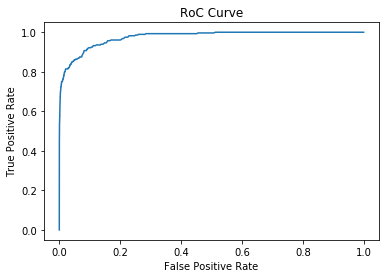

In [153]:
min_threshold = np.amin(np.reshape(A, np.prod(A.shape)))
max_threshold = np.amax(np.reshape(A, np.prod(A.shape)))
tpr, fpr, eer = roc_curve(min_threshold, max_threshold, 1000)

In [154]:
print("Minimum threshold: {0:f}".format(min_threshold))
print("Maximum threshold: {0:f}".format(max_threshold))
print("Equal Error Rate is at threshold = {0:f}".format(eer))

Minimum threshold: 1.742015
Maximum threshold: 17.541726
Equal Error Rate is at threshold = 8.084041


## Principle Component Analysis (PCA)

PCA is a method for dimensionality reduction that is very flexible and fits many use cases. It is unsupervised (needs no class label). The core of PCA is using eigendecomposition to decompose the data into the directions of maximum variance.

Let’s define a matrix $X$ with each column as an input sample $\vec{x_{i}}$

A typical PCA starts by normalizing each feature dimension so that they have equal range. For our case, since our input vectors are already between $0$ and $1$, we can skip this step.

The first step of PCA is to first remove the global mean from our data. Let $\vec{\mu_{x}}$ be the means of the input data along each input dimension. Let $\hat{X}$ be the matrix with the mean of the input samples removed. Be sure to use the mean computed from just the training examples.

**Compute the mean vector from the training images. Show the vector as an image (use `numpy.reshape()`). This is typically called the meanface (or meanvoice for speech signals).**
<font color=red>**Answer**</font><br>
The answer is in the code cells below.

In [175]:
T = np.array(T)
D = np.array(T)
X = np.reshape(T, (T.shape[0], T.shape[1] * T.shape[2]))
X = X.T

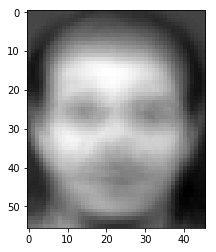

In [171]:
# Calculate meanface
mu_X = np.mean(X, axis = 1)
plt.imshow(np.reshape(mu_X, (image_resolution[0], image_resolution[1])), cmap = "gray")
plt.show()

In [192]:
# calculate X_hat (the matrix with the mean of the input samples removed)
X_hat = X - np.array([mu_X] * 120).T
X_hat.shape

(2576, 120)

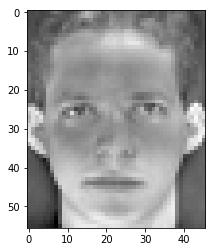

In [191]:
plt.imshow(np.reshape(X_hat[:, 0], (image_resolution[0], image_resolution[1])), cmap = "gray")
plt.show()

We can then compute eigenvectors on the covariance matrix computed from $\hat{X}$. The PCA vectors would correspond to the eigenvectors, $v$. In other words, 
$$\mathbf{Σ}\vec{v} = \lambda\vec{v}$$
However, as learned in class, if we compute the covariance matrix, we would need a lot of space to store it.

**What is the size of the covariance matrix? What is the rank of the covariance matrix?**
<font color=red>**Answer**</font><br>
The covariance matrix's size is 2576 x 2576 with rank 119.

In [199]:
X_hat_cov = np.cov(X_hat)
print("The covariance matrix's size: {0:d} x {1:d}".format(X_hat_cov.shape[0], X_hat_cov.shape[1]))
X_hat_cov_rank = np.linalg.matrix_rank(X_hat_cov)
print("The rank of the covariance matrix: {0:d}".format(X_hat_cov_rank))

The covariance matrix's size: 2576 x 2576
The rank of the covariance matrix: 119


The trick we learned in class is to compute the Gram Matrix $(\hat{X}^T\hat{X})$, which is the inner product between the input matrices.

**What is the size of the Gram matrix? What is the rank of Gram matrix? If we compute the eigenvalues from the Gram matrix, how many non-zero eigenvalues do we expect to get?**
<font color=red>**Answer**</font><br>
The Gram matrix's size is 120 x 120 with rank 119. <br>
For $N x N$ Hermitian matrix, "its rank = number of its non-zero eigen values".<br>
Since a real symmetric matrix is Hermitian, there are 119 non-zero eigenvalues.

In [207]:
X_gram_matrix = np.dot(X_hat.T, X_hat)
print("The Gram matrix's size: {0:d} x {1:d}".format(X_gram_matrix.shape[0], X_gram_matrix.shape[1]))
X_gram_matrix_rank = np.linalg.matrix_rank(X_gram_matrix)
print("The rank of Gram matrix: {0:d}".format(X_gram_matrix_rank))

The Gram matrix's size: 120 x 120
The rank of Gram matrix: 119


**Is the Gram matrix also symmetric? Why?**
<font color=red>**Answer**</font><br>
Yes. Because it is the inner product between the input matrices and for every matrix $A$, $A^TA$ is always square and symmetric.

$$(A^{T}A)^{T} = A^{T}(A^{T})^{T}$$
$$ = A^{T}A$$
Hence; by the definition of symmetry, $A^{T}A$ is symmetric.

Using the gram matrix, we instead solve for the eigenvector, $\vec{v'}$.
$$\hat{X}^T\hat{X}\vec{v'} = \lambda\vec{v'}$$
where the desired eigenvector can be compute from $\vec{v'}$ using the following relationship
$$\vec{v}=\hat{X}\vec{v'}$$

In order to compute the eigenvectors and eigenvalues, we can use the function `numpy.linalg.eigh` which can be used on symmetric matrices. For symmetric matrices, the eigenvectors and eigenvalues will always be real. In contrast, if the matrix is not symmetric, we have to use the function `numpy.linalg.eig` which will output complex numbers.

**Compute the eigenvectors and eigenvalues of the Gram matrix, $\vec{v'}$ and $\lambda$. Sort the eigenvalues and eigenvectors in descending order so that the first eigenvalue is the highest, and the first eigenvector corresponds to the best direction. How many non-zero eigenvectors are there? If you see a very small value, it is just numerical error and should be treated as zero.**
<font color=red>**Answer**</font><br>
There are 119 non-zero eigenvalues as we expected.

In [208]:
gram_eigenvalues, gram_eigenvectors = np.linalg.eigh(X_gram_matrix)

In [288]:
# sort the eigenvalues and eigenvectors in descending order
gram_eigenvalues_asd_sorted_idx = gram_eigenvalues.argsort()
gram_eigenvalues_des_sorted_idx = gram_eigenvalues_sorted_idx[::-1]
gram_eigenvalues_des = gram_eigenvalues[gram_eigenvalues_des_sorted_idx]
gram_eigenvectors_des = (gram_eigenvectors.T[gram_eigenvalues_des_sorted_idx]).T

In [291]:
# number of non-zero eigenvalues
print("Number of non-zero eigenvalues: {0:d}".format(np.where(gram_eigenvalues_des > 1e-6)[0].shape[0]))

Number of non-zero eigenvalues: 119


**Plot the eigenvalues. Observe how fast the eigenvalues decrease. In class, we learned that the eigenvalues is the size of the variance for each eigenvector direction. If I want to keep 95% of the variance in the data, how many eigenvectors should I use?**
<font color=red>**Answer**</font><br>
64 eigenvectors should be used in order to keep 95% of the variance in the data.

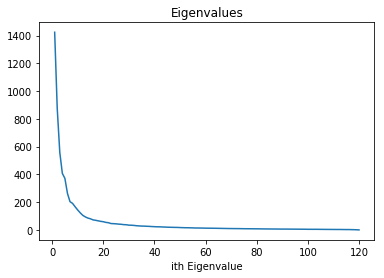

In [292]:
# plot the eigenvalues
plt.plot([i + 1 for i in range(len(gram_eigenvalues_des))], gram_eigenvalues_des)
plt.xlabel('ith Eigenvalue')
plt.title('Eigenvalues')
plt.show()

In [293]:
total_variance = np.sum(gram_eigenvalues_des[0:119])
cumulative_variance = gram_eigenvalues_des[0]
ninety_five_var_idx = 0
for i in range(1, 119):
    cumulative_variance = cumulative_variance + gram_eigenvalues_des[i]
    ninety_five_var_idx = i
    if(cumulative_variance >= 0.95 * total_variance):
        break
print("{0:d} eigenvectors should be used in order to keep 95% of the variance in the data.".format(ninety_five_var_idx + 1))

64 eigenvectors should be used in order to keep 95% of the variance in the data.


**Compute $\vec{v}$. Don’t forget to renormalize so that the norm of each vector is 1 (you can use `numpy.linalg.norm`). Show the first $10$ eigenvectors as images.**
<font color=red>**Answer**</font><br>
The answer is in the code cells and their output below.

In [325]:
V = np.dot(X_hat, gram_eigenvectors_des)
V_normalized = V / np.linalg.norm(V, axis = 0)

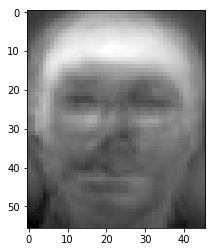

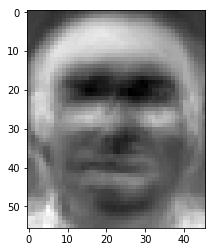

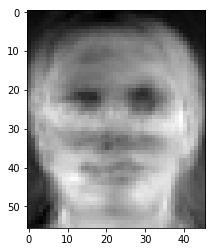

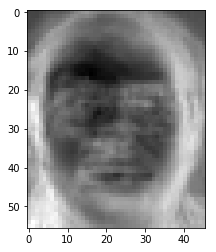

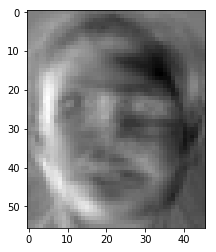

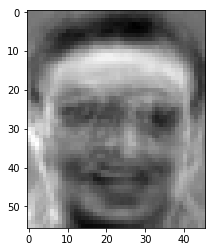

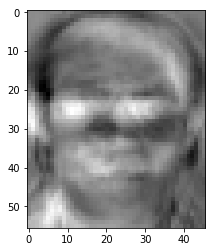

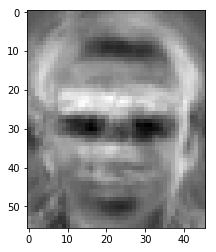

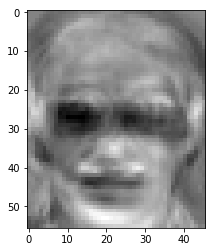

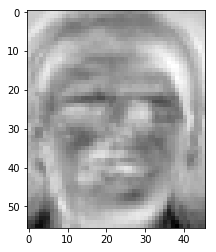

In [338]:
for i in range(10):
    plt.imshow(np.reshape(V_normalized[:, i], (image_resolution[0], image_resolution[1])), cmap = "gray")
    plt.show()

<img src="./images/example-eigenfaces.png" width="30%" height="30%">
**From the image, what do you think the first eigenvector captures? What about the second eigenvector? Look at the original images, do you think biggest variance are capture in these two eigenvectors?**
<font color=red>**Answer**</font><br>
From the images above, I think the first eigenvector captures hair, and glasses. The second one captures hair, eyes, lip and the part below neck. And yes, I think the biggest variance are capture in these two eigenvectors.